In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_rel
import statsmodels.api as sm
import seaborn as sns
import pickle



from utils import *

%load_ext autoreload
%autoreload 2
sns.set_context("talk")
condition = 'hf'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Outline

## Load in
- Load in the three datasets (race1, race2, base)


In [55]:
DM_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/code/jess/design_matrices")
### READ IN
y = pd.read_csv(DM_PATH / f"{condition}_y.csv", index_col=False)
y = y.squeeze()

X_race_1 = pd.read_csv(DM_PATH / f"{condition}_X_race1.csv")
X_race_2 = pd.read_csv(DM_PATH / f"{condition}_X_race2.csv")
X_base = pd.read_csv(DM_PATH / f"{condition}_X_base.csv")

create standardized versions of each with added constant


In [56]:
# Standardized with mean 0, std 1
X_race_1_s = process_features(
    X_race_1,
    numeric_cols=X_race_1.columns,
)
X_race_2_s = process_features(
    X_race_2,
    numeric_cols=X_race_2.columns,
)
X_base_s = process_features(
    X_base,
    numeric_cols=X_base.columns,
)

In [22]:
# sns.pairplot(X_race_1_s, corner=True)

In [23]:
# sns.pairplot(X_race_2_s, corner=True)

In [24]:
# sns.pairplot(X_base_s, corner=True)

In [57]:
X_race_1_s = sm.add_constant(X_race_1_s)
X_race_2_s = sm.add_constant(X_race_2_s)
X_base_s = sm.add_constant(X_base_s)

In [58]:
assert len(X_race_1_s) == len(y) == len(X_race_2_s) == len(X_base_s), "lengths off!"
assert (
    X_race_2_s.shape[1] > X_race_1_s.shape[1] > X_base_s.shape[1]
), "columns incorrect!"
assert "readmission_rate" not in X_race_2_s.columns, "contains rr!!!"


## Linear Model
### Fit w/ CV
- run k_fold cross validation for 1, 2, base with same split for each fold
    - save out MSE, R^2 for each fold into a dataframe that also contains condition name, model type and model name



In [81]:
k = 10  # Number of folds

# Step 3: Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=86)

# Initialize lists to store the RMSE and adjusted R-squared values for each model
lm_results = []

for i, (train_index, test_index) in enumerate(kf.split(X_base_s)):
    # Split the data into training and validation sets for the three models
    # with different feature sets, but same y
    X_train_base, X_test_base = (
        X_base_s.iloc[train_index],
        X_base_s.iloc[test_index],
    )
    X_train_race_1, X_test_race_1 = (
        X_race_1_s.iloc[train_index],
        X_race_1_s.iloc[test_index],
    )
    X_train_race_2, X_test_race_2 = (
        X_race_2_s.iloc[train_index],
        X_race_2_s.iloc[test_index],
    )

    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ## BASE
    # Train and evaluate
    lm_model = sm.OLS(y_train, X_train_base).fit()
    y_pred = lm_model.predict(X_test_base)

    # Store the results for the base model
    result_dict = {
        "condition": "hf",
        "model_name": "Base",
        "model_type": "LM",
        "fold": i,
        "r2": lm_model.rsquared_adj,
        "mse": mean_squared_error(y_test, y_pred),
    }
    lm_results.append(result_dict)

    ## RACE 1
    # Train and evaluate
    lm_model = sm.OLS(y_train, X_train_race_1).fit()
    y_pred = lm_model.predict(X_test_race_1)

    # Store the results for the base model
    result_dict = {
        "condition": "hf",
        "model_name": "Base + Race 1",
        "model_type": "LM",
        "fold": i,
        "r2": lm_model.rsquared_adj,
        "mse": mean_squared_error(y_test, y_pred),
    }
    lm_results.append(result_dict)

    ## RACE 2
    # Train and evaluate
    lm_model = sm.OLS(y_train, X_train_race_2).fit()
    y_pred = lm_model.predict(X_test_race_2)

    # Store the results for the base model
    result_dict = {
        "condition": "hf",
        "model_name": "Base + Race 2",
        "model_type": "LM",
        "fold": i,
        "r2": lm_model.rsquared_adj,
        "mse": mean_squared_error(y_test, y_pred),
    }
    lm_results.append(result_dict)

lm_results = pd.DataFrame(lm_results)
lm_results["rmse"] = np.sqrt(lm_results["mse"])


### Eval
- plot performance of each model (RMSE + R^2) for each fold

In [196]:
lmpal = sns.color_palette("rocket", 4)
lmpal = lmpal.as_hex()
lmpal

['#4c1d4b', '#a11a5b', '#e83f3f', '#f69c73']

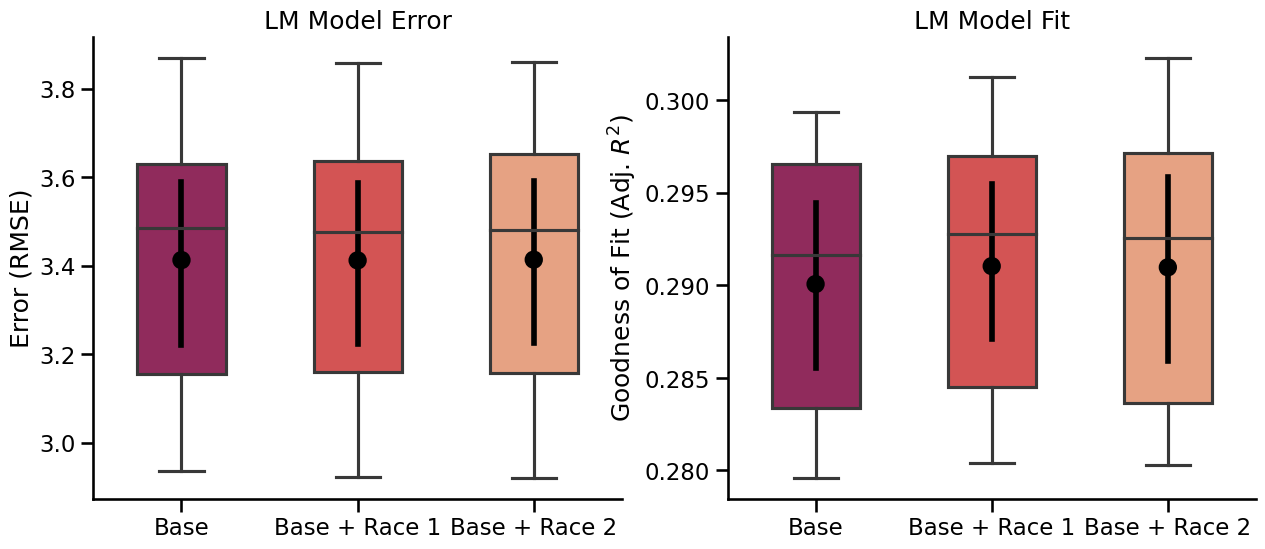

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.despine()

plot_single_model_results(lm_results, ax, palette=lmpal[1:])

In [222]:
print("LINEAR MODEL RESULTS")
run_mse_r2_sig_test(lm_results)

LINEAR MODEL RESULTS
r2 p-value: 0.953333399198806
rmse p-value: 0.9999307791197749



### Feature analysis
- run a full fit for each model and plot coefficients


In [142]:
lm_base = sm.OLS(y, X_base_s)
lm_base = lm_base.fit()

lm_race_1 = sm.OLS(y, X_race_1_s)
lm_race_1 = lm_race_1.fit()

lm_race_2 = sm.OLS(y, X_race_2_s)
lm_race_2 = lm_race_2.fit()

print(f"base model r^2 : {np.round(lm_base.rsquared_adj, 4)}")
print(f"race 1 model r^2 : {np.round(lm_race_1.rsquared_adj, 4)}")
print(f"race 2 model r^2 : {np.round(lm_race_2.rsquared_adj, 4)}")

base model r^2 : 0.2897
race 1 model r^2 : 0.2906
race 2 model r^2 : 0.2905


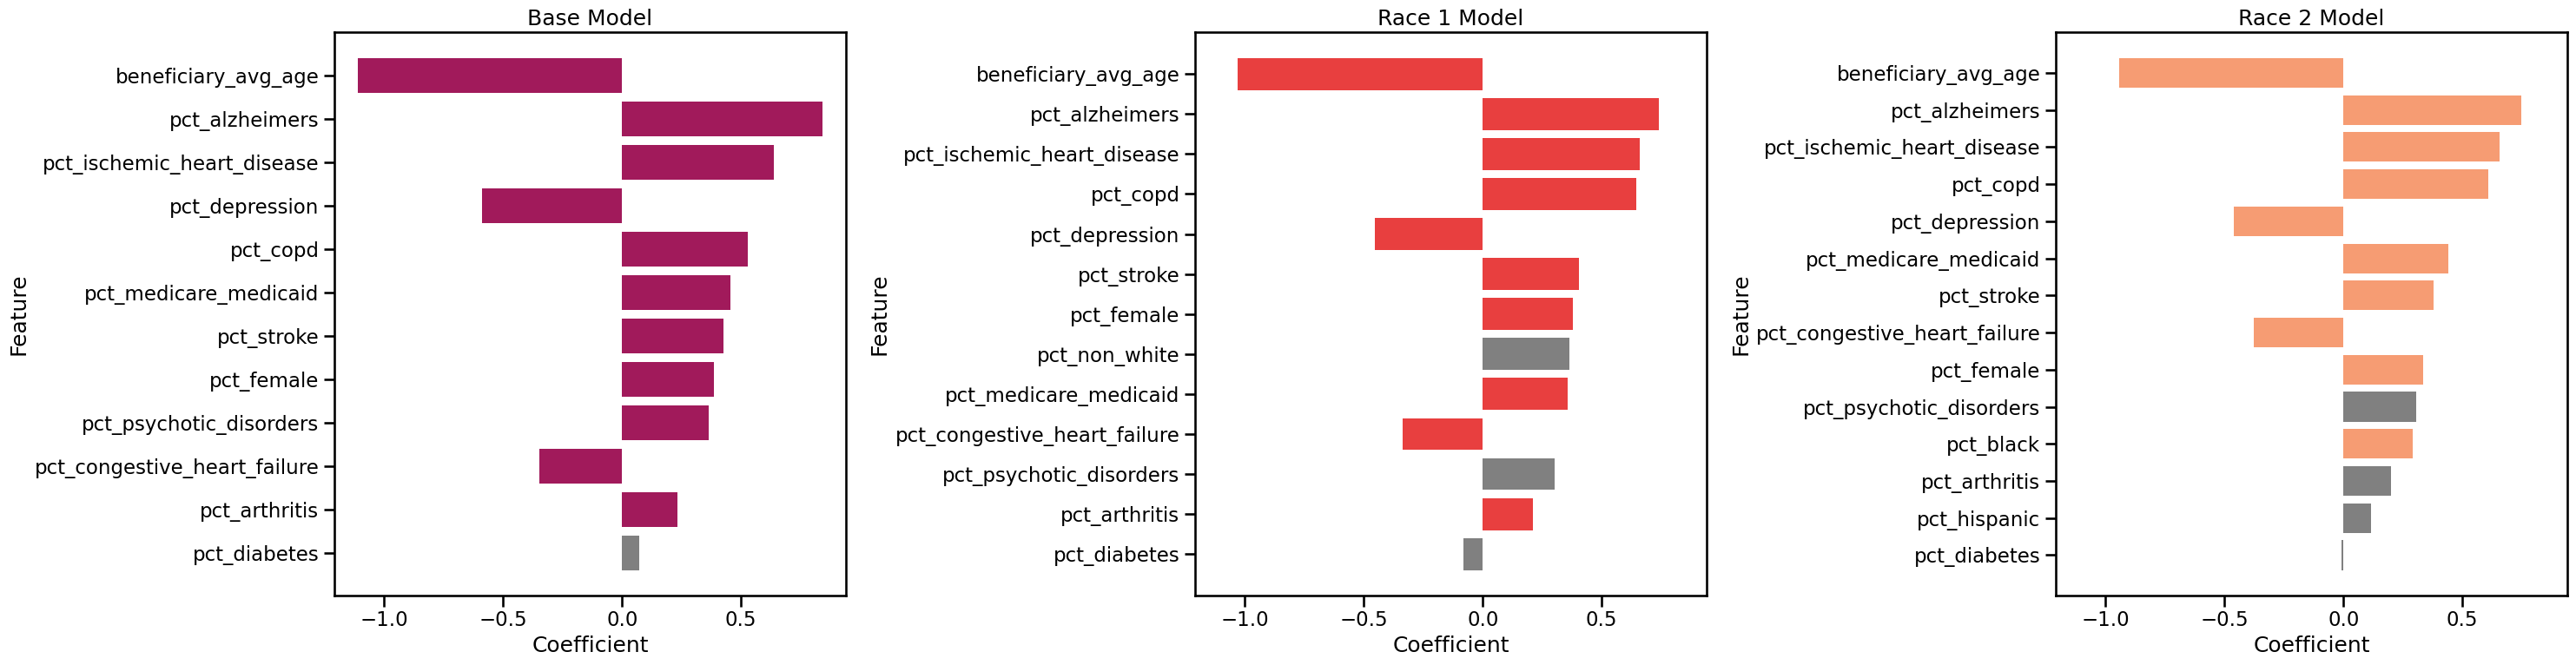

In [193]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8), sharex=True)

plot_feature_weights_horizontal_sm(
    lm_base, ax=ax[0], color=lmpal[1], title="Base Model"
)
plot_feature_weights_horizontal_sm(
    lm_race_1, ax=ax[1], color=lmpal[2], title="Race 1 Model"
)
plot_feature_weights_horizontal_sm(
    lm_race_2, ax=ax[2], color=lmpal[3], title="Race 2 Model"
)


plt.tight_layout()


## Random Forest


In [223]:
rfpal = sns.color_palette("mako", 4)
rfpal = rfpal.as_hex()
rfpal

['#382a54', '#395d9c', '#3497a9', '#60ceac']


### Hyperparams
- for each model, grid search for hyperparams (or just do one or two)


In [211]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search through
param_grid = {
    "n_estimators": [100, 150, 200, 250],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [10, 20, 40],
    "min_samples_leaf": [2, 4, 8, 16, 32],
    "max_features": ["auto", "sqrt"],
}

In [212]:
# Initialize the random forest model
base_model = RandomForestRegressor(random_state=87)

# Perform GridSearchCV for hyperparameter tuning
base_grid_search = GridSearchCV(
    estimator=base_model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5
)
base_grid_search.fit(X_base, y)

/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1200 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/base.

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=87),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 8, 16, 32],
                         'min_samples_split': [10, 20, 40],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [213]:
# Print the best hyperparameters and the corresponding RMSE
print("Best Hyperparameters for Base Model :", base_grid_search.best_params_)
print("Best RMSE for Base Model :", np.sqrt(-base_grid_search.best_score_))

Best Hyperparameters for Base Model : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 10, 'n_estimators': 250}
Best RMSE for Base Model : 3.45297517008649


In [214]:
# Initialize the random forest model
race_1_model = RandomForestRegressor(random_state=87)

# Perform GridSearchCV for hyperparameter tuning
race_1_grid_search = GridSearchCV(
    estimator=race_1_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
)
race_1_grid_search.fit(X_race_1, y)

/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1200 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/base.

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=87),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 8, 16, 32],
                         'min_samples_split': [10, 20, 40],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [215]:
# Print the best hyperparameters and the corresponding RMSE
print("Best Hyperparameters for Race 1 Model :", race_1_grid_search.best_params_)
print("Best RMSE for Race 1 Model :", np.sqrt(-race_1_grid_search.best_score_))

Best Hyperparameters for Race 1 Model : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
Best RMSE for Race 1 Model : 3.445309577356966


In [216]:
# Initialize the random forest model
race_2_model = RandomForestRegressor(random_state=87)

# Perform GridSearchCV for hyperparameter tuning
race_2_grid_search = GridSearchCV(
    estimator=race_2_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
)
race_2_grid_search.fit(X_race_2, y)

/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1200 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/sklearn/base.

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=87),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 8, 16, 32],
                         'min_samples_split': [10, 20, 40],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [217]:
# Print the best hyperparameters and the corresponding RMSE
print("Best Hyperparameters for Race 2 Model :", race_2_grid_search.best_params_)
print("Best RMSE for Race 2 Model :", np.sqrt(-race_2_grid_search.best_score_))

Best Hyperparameters for Race 2 Model : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 40, 'n_estimators': 250}
Best RMSE for Race 2 Model : 3.4397525513927185


In [219]:
RESULTS_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/code/jess/results")
# Create a new dictionary to store all three dictionaries with appropriate keys
combined_dict = {
    "base": base_grid_search.best_params_,
    "race_1": race_1_grid_search.best_params_,
    "race_2": race_2_grid_search.best_params_,
}

# Save the combined dictionary as a pickle file
with open(RESULTS_PATH / "rf_hyperparams_hf.pickle", "wb") as file:
    pickle.dump(combined_dict, file)


### Fit w/ CV
- run k_fold cross validation for 1, 2, base with same split for each fold
    - save out MSE, R^2 for each fold into a dataframe that also contains condition name, model type and model name



In [224]:
k = 10  # number of folds

# perform validation
kf = KFold(n_splits=k, shuffle=True, random_state=82)


# initialize list to store metrics for each model
rf_results = []


for i, (train_index, test_index) in enumerate(kf.split(X_base)):
    # Split the data into training and validation sets for the three models
    # with different feature sets, but same y
    X_train_base, X_test_base = (
        X_base.iloc[train_index],
        X_base.iloc[test_index],
    )
    X_train_race_1, X_test_race_1 = (
        X_race_1.iloc[train_index],
        X_race_1.iloc[test_index],
    )
    X_train_race_2, X_test_race_2 = (
        X_race_2.iloc[train_index],
        X_race_2.iloc[test_index],
    )

    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ## BASE
    # Train and evaluate
    rf_model = RandomForestRegressor(random_state=87, **base_grid_search.best_params_)
    rf_model.fit(X_train_base, y_train)
    y_pred = rf_model.predict(X_test_base)

    # Store the results
    result_dict = {
        "condition": condition,
        "model_name": "Base",
        "model_type": "RF",
        "fold": i,
        "r2": r2_score(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
    }
    rf_results.append(result_dict)

    ## RACE 1
    # Train and evaluate
    rf_model = RandomForestRegressor(random_state=87, **race_1_grid_search.best_params_)
    rf_model.fit(X_train_race_1, y_train)
    y_pred = rf_model.predict(X_test_race_1)

    # Store the results
    result_dict = {
        "condition": condition,
        "model_name": "Base + Race 1",
        "model_type": "RF",
        "fold": i,
        "r2": r2_score(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
    }
    rf_results.append(result_dict)

    ## RACE 2
    # Train and evaluate
    rf_model = RandomForestRegressor(random_state=87, **race_2_grid_search.best_params_)
    rf_model.fit(X_train_race_2, y_train)
    y_pred = rf_model.predict(X_test_race_2)

    # Store the results
    result_dict = {
        "condition": condition,
        "model_name": "Base + Race 2",
        "model_type": "RF",
        "fold": i,
        "r2": r2_score(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
    }
    rf_results.append(result_dict)

rf_results = pd.DataFrame(rf_results)
rf_results["rmse"] = np.sqrt(rf_results["mse"])


### Eval
- plot performance of each model (RMSE + R^2) for each fold


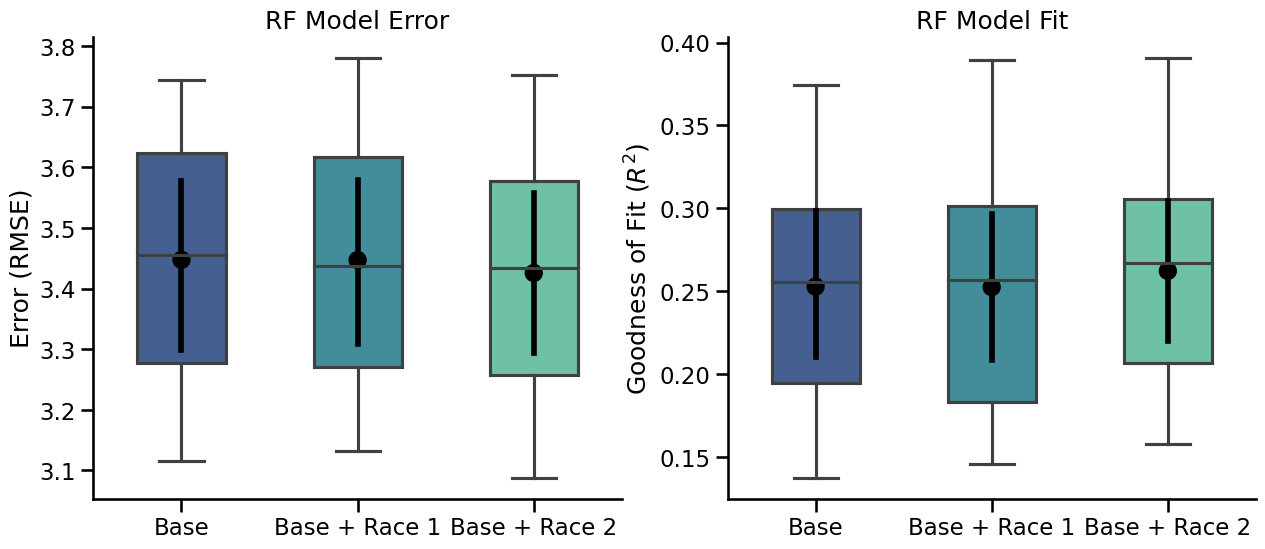

In [226]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.despine()

plot_single_model_results(rf_results, ax, palette=rfpal[1:])

In [227]:
print("RANDOM FOREST RESULTS")
run_mse_r2_sig_test(rf_results)

RANDOM FOREST RESULTS
r2 p-value: 0.9473902051504584
rmse p-value: 0.9714980961672303



### Feature analysis
- run feature importance for each model (or just one race one?)


In [228]:
# Initialize the random forest model for each model with the best params & fit
## BASE
rf_base = RandomForestRegressor(random_state=87, **base_grid_search.best_params_)
rf_base.fit(X_base, y)

## RACE 1
rf_race_1 = RandomForestRegressor(random_state=87, **race_1_grid_search.best_params_)
rf_race_1.fit(X_race_1, y)

## RACE 2
rf_race_2 = RandomForestRegressor(random_state=87, **race_2_grid_search.best_params_)
rf_race_2.fit(X_race_2, y)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=40, n_estimators=250, random_state=87)

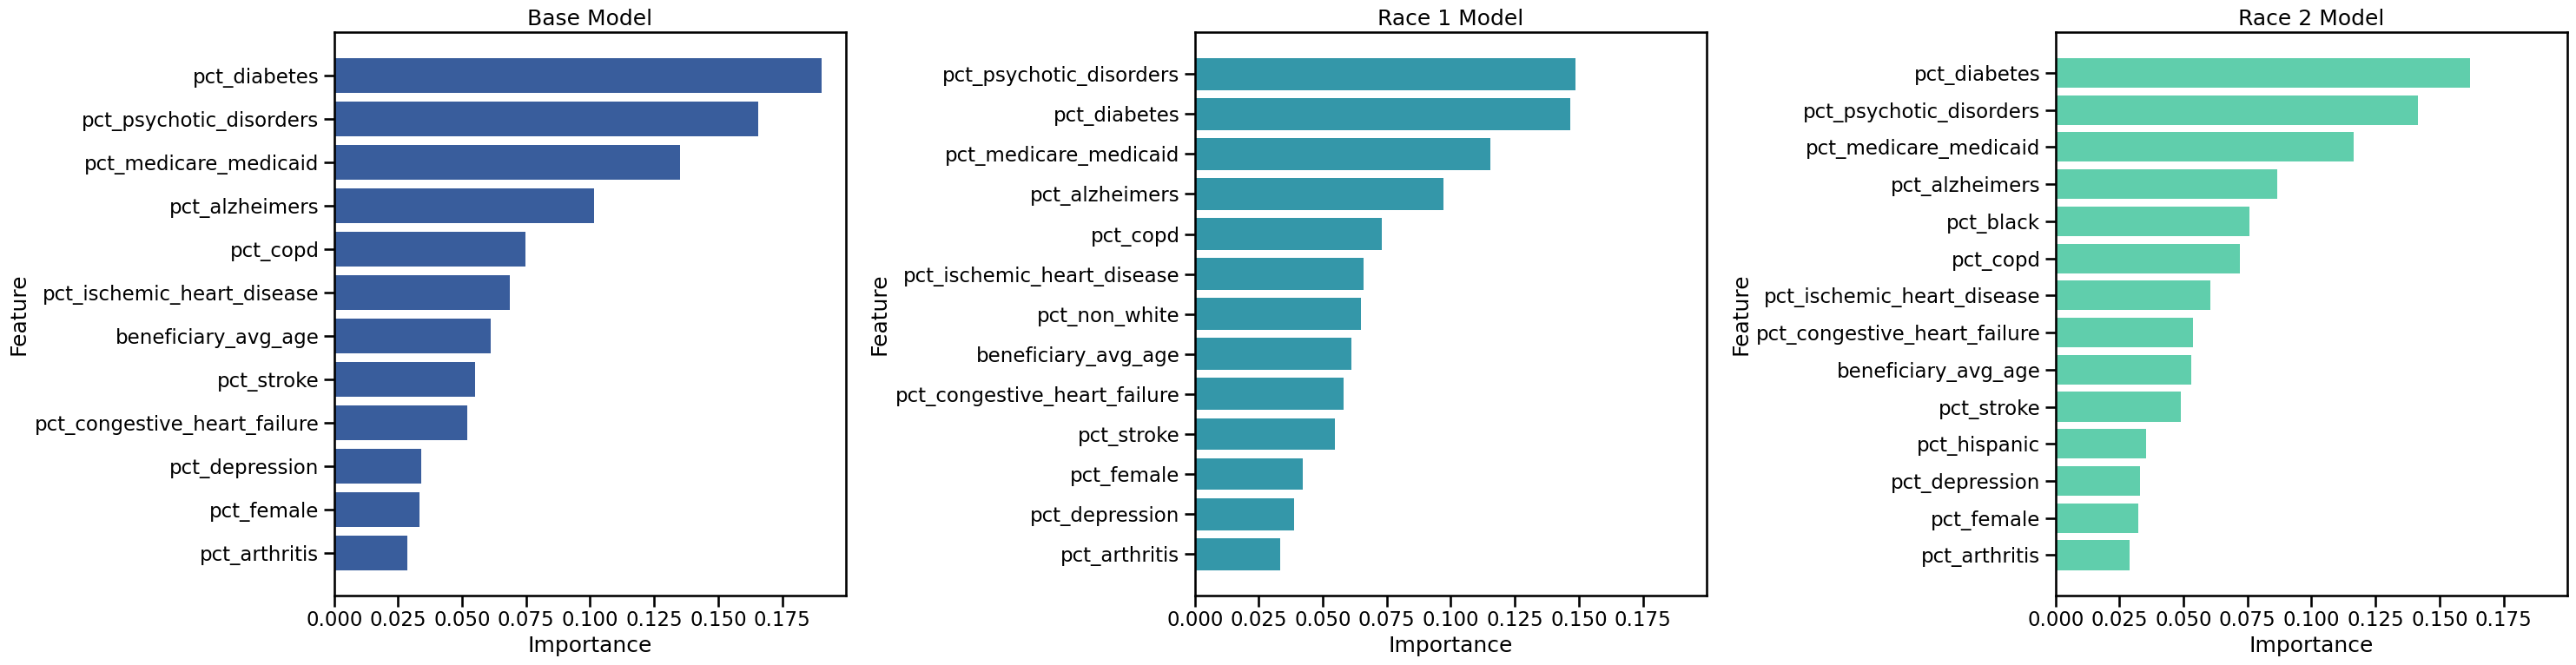

In [229]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8), sharex=True)

plot_rf_importances(rf_base, X_base, ax=ax[0], color=rfpal[1], title="Base Model")
plot_rf_importances(rf_race_1, X_race_1, ax=ax[1], color=rfpal[2], title="Race 1 Model")
plot_rf_importances(rf_race_2, X_race_2, ax=ax[2], color=rfpal[3], title="Race 2 Model")


plt.tight_layout()

In [232]:
get_rf_importance_df(rf_race_1, X_race_1, condition)


## Save out

- merge lm and hf dataframes into a larger results_df. 

In [230]:
# save out as csv

pd.concat([lm_results, rf_results], ignore_index=True).to_csv(
    RESULTS_PATH / f"{condition}_models_results.csv", index=False
)